In [37]:
import librosa
import librosa.display
import pyaudio
import queue
from typing import Optional
import numpy as np
import time
import matplotlib.pyplot as plt
import datetime
from collections import deque
import IPython.display 
from IPython.display import clear_output

SAMPLE_RATE = 22050
HOP_LENGTH = 256
CHANNELS = 1
N_FFT = 512
feature_rate = int(SAMPLE_RATE / HOP_LENGTH)

In [38]:
class StreamProcessor:
    def __init__(self, sample_rate=SAMPLE_RATE, chunk_size=1024, verbose=True):
        self.chunk_size = chunk_size
        self.channels = CHANNELS
        self.sample_rate = sample_rate
        self.verbose = verbose
        self.format = pyaudio.paFloat32
        self.audio_interface: Optional[pyaudio.PyAudio] = None
        self.audio_stream: Optional[pyaudio.Stream] = None
        self.buffer = queue.Queue()
        self.chroma_buffer = queue.Queue()
        self.last_chunk = None
        self.is_mic_open = False
        self.index = 0

    def _process_frame(self, data, frame_count, time_info, status_flag):
        if self.verbose:
            print(f'\nprocess_frame index: {self.index}, frame_count: {frame_count}')
            print(f"{self.index}st time_info: {time_info}")

        self.buffer.put(data)

        query_audio = np.frombuffer(data, dtype=np.float32)
        query_chroma_stft = librosa.feature.chroma_stft(
            y=query_audio, hop_length=HOP_LENGTH, n_fft=N_FFT
        )
        if self.last_chunk is None:  # first audio chunk is given
            current_chunk = {
                "timestamp": time_info["input_buffer_adc_time"],
                "chroma_stft": query_chroma_stft[:, :-1],
            }
            self.chroma_buffer.put(current_chunk)
            # self.chroma_buffer.put(query_chroma_stft[:, :-1])  # pop last frame converted with zero padding
        else:
            override_previous_padding = librosa.feature.chroma_stft(
                y=np.concatenate((self.last_chunk, query_audio[:HOP_LENGTH])),
                sr=self.sample_rate,
                hop_length=HOP_LENGTH,
                n_fft=N_FFT,
            )[:, 1:-1]  # drop first and last frame converted with zero padding
            accumulated_chroma = np.concatenate((override_previous_padding, query_chroma_stft[:, 1:-1]), axis=1)
            current_chunk = {
                "timestamp": time_info["input_buffer_adc_time"] + HOP_LENGTH / SAMPLE_RATE,
                "chroma_stft": accumulated_chroma,
            }
            self.chroma_buffer.put(current_chunk)
        
        if self.verbose:
            print(f"[PUT] for {self.index}st frame")
            print(f"queue inside at {self.index}: {self.chroma_buffer.qsize()}")
        self.last_chunk = query_audio[query_audio.shape[0] - HOP_LENGTH:]
        self.index += 1
        return (data, pyaudio.paContinue)

    def run(self):
        self.audio_interface = pyaudio.PyAudio()
        self.audio_stream = self.audio_interface.open(
            format=self.format,
            channels=self.channels,
            rate=self.sample_rate,
            input=True,
            frames_per_buffer=self.chunk_size,
            stream_callback=self._process_frame,
        )
        self.is_mic_open = True
        self.audio_stream.start_stream()
        self.start_time = self.audio_stream.get_time()
        print("* Recording in progress....")

    def stop(self):
        if self.is_mic_open:
            self.audio_stream.stop_stream()
            self.audio_stream.close()
            self.is_mic_open = False
            self.audio_interface.terminate()
            print("Recording Stopped.")

In [61]:
MAX_LEN = int(1e4)
HOP_LENGTH = 256

from enum import IntEnum
import scipy


class Direction(IntEnum):
    REF = 1
    QUERY = 2
    BOTH = REF | QUERY


class OnlineTimeWarping:
    def __init__(
        self,
        sp: StreamProcessor,
        ref_audio_path,
        window_size,
        max_run_count=30,
        hop_length=HOP_LENGTH,
        verbose=True,
    ):
        self.sp = sp
        self.window_size = window_size
        self.max_run_count = max_run_count
        self.hop_length = hop_length
        self.frame_per_seg = int(sp.chunk_size / hop_length)
        self.verbose = verbose
        self.q_index = 0
        self.ref_pointer = 0
        self.time_length = 0
        self.distance = 0
        self.run_count = 0
        self.previous_direction = None
        self.current_query_stft = None  # (12, n)
        self.query_stft = np.zeros((12, MAX_LEN))  # (12, N) stft of total query
        self.query_audio = np.array([])
        self.index1s = np.array([])
        self.index2s = np.array([])
        self.warping_path = None
        self.cost_matrix = np.zeros((self.window_size * self.frame_per_seg + 1, self.window_size * self.frame_per_seg + 1))
        self.dist_matrix = np.zeros((self.window_size * self.frame_per_seg, self.window_size * self.frame_per_seg))
        self.iteration = 0
        self.cost_matrix_offset = [0, 0] # (ref, query)
        self.q_index = 0

        self.initialize_ref_audio(ref_audio_path)
    
    def offset(self):
        window_frame_length = self.frame_per_seg * self.window_size
        return np.array([self.ref_pointer - window_frame_length, self.q_index - window_frame_length])

    def initialize_ref_audio(self, audio_path):
        audio_y, sr = librosa.load(audio_path)
        self.ref_audio = audio_y
        ref_stft = librosa.feature.chroma_stft(y=audio_y, sr=sr, hop_length=HOP_LENGTH, n_fft=N_FFT)
        ref_len = ref_stft.shape[1]
        truncated_len = ((ref_len - 1) // self.frame_per_seg ) * self.frame_per_seg  # initialize_ref_audio 에서 ref_stft 길이가 frame_per_seg (4) 로 나눠지게 마지막을 버림
        self.ref_stft = ref_stft[:, :truncated_len]

        self.global_cost_matrix = np.zeros((self.ref_stft.shape[1] * 2, self.ref_stft.shape[1] * 2))

    def init_dist_matrix(self):
        print('init')
        ref_stft_seg = self.ref_stft[:, :self.ref_pointer] # [F, M]
        query_stft_seg = self.query_stft[:, :self.q_index] # [F, N] 
        dist = scipy.spatial.distance.cdist(ref_stft_seg.T, query_stft_seg.T)

        if self.verbose:
            print(f"ref_stft_seg: {ref_stft_seg.shape}, query_stft_seg: {query_stft_seg.shape}, dist: {dist.shape}, dist_matrix shape: {self.dist_matrix.shape}")
        w = self.window_size * self.frame_per_seg
        self.dist_matrix[w  - dist.shape[0]:, w - dist.shape[1]:] = dist
    
    def update_dist_matrix(self, direction: Direction):
        if self.verbose:
            print(f"update_path_cost with direction: {direction.name}")
        x = self.ref_pointer
        y = self.q_index
        w = self.window_size * self.frame_per_seg

        ref_stft_seg = self.ref_stft[:, max(x - w, 0) : x] # [F, M]
        query_stft_seg = self.query_stft[:, max(y - w, 0) : y] # [F, N]
        dist = scipy.spatial.distance.cdist(ref_stft_seg.T, query_stft_seg.T)
        if self.verbose:
            print(f"current pointer: {(x, y)}, ref shape: {ref_stft_seg.shape} query shape: {query_stft_seg.shape}, dist shape: {dist.shape}, dist_matrix shape: {self.dist_matrix.shape}")

        self.dist_matrix[w - dist.shape[0]:, w - dist.shape[1]:] = dist  # dist_matrix 끝 점에 맞춰서 항상 업데이트 되도록 함.
    
    def update_accumulate_matrix(self):
        # local cost matrix
        x = self.ref_pointer
        y = self.q_index
        w = self.window_size * self.frame_per_seg
        ref_stft_seg = self.ref_stft[:, max(x - w, 0) : x].T # [M, 12]
        query_stft_seg = self.query_stft[:, max(y - w, 0) : y].T # [N, 12]
        print(f"ref_stft_seg: {ref_stft_seg.shape}, query_stft_seg: {query_stft_seg.shape}")
        
        table = np.zeros((w + 1, w + 1))
        print(f"table shape: {table.shape}")
        
        # Compute left column separately, i.e. j=0.
        table[1:, 0] = np.inf
            
        # Compute top row separately, i.e. i=0.
        table[0, 1:] = np.inf

        for i in range(1, w + 1):
            for j in range(1, w + 1):
                print(f"i, j: ({i, j})")
                d = scipy.spatial.distance.euclidean(ref_stft_seg[i - 1], query_stft_seg[j - 1])
                table[i, j] = d + min(table[i - 1, j], table[i, j - 1], table[i - 1, j - 1])

        self.cost_matrix = table

    def update_direction_matrix(self):
        pass
    
    def calculate_warping_path(self, start, end):
        """calculate each warping path from start to end point and return distance
        """
        wp = None
        distance = None
        return wp, distance

    def update_warping_path(self):
        table = self.cost_matrix
        i = self.dist_matrix.shape[0]
        j = self.dist_matrix.shape[1]
        
        ref_until = 0
        query_until = 0
        
        offset = self.offset()
        if offset[0] < 0 or offset[1] < 0:
            ref_until = max(i - self.ref_pointer, 0)
            query_until = max(j - self.q_index, 0)
#         if self.verbose:
        print(f"cost_matrix: {table.shape} i: {i}, j: {j}, ref until: {ref_until}, query until: {query_until}")
        path = [(i, j)]
        while i > ref_until and j > query_until:
            minval = np.inf
            if self.verbose:
                print(f"inside while; i: {i}, j: {j}")
            if table[i-1, j] < minval:
                minval = table[i-1, j]
                step = (i-1, j)
            if table[i][j-1] < minval:
                minval = table[i, j-1]
                step = (i, j-1)
            if table[i-1][j-1] < minval:
                minval = table[i-1, j-1]
                step = (i-1, j-1)
            path.insert(0, step)
            i, j = step
        path += self.offset()
        self.warping_path = path

    def update_path_cost(self, direction: Direction = Direction.BOTH):
        # self.update_dist_matrix(direction)
        self.update_accumulate_matrix()
        self.update_direction_matrix()
        self.update_warping_path()

    def select_next_direction(self):
        '''
        if self.run_count > self.max_run_count:
            if self.previous_direction == Direction.REF:
                next_direction = Direction.QUERY
            else:
                next_direction = Direction.REF

        last_ref_path, last_query_path = self.warping_path[0]
        if (
            last_ref_path + 1 == self.ref_pointer
            and last_query_path + 1 == self.query_pointer
        ):
            next_direction = Direction.BOTH
        elif last_ref_path < last_query_path:
            next_direction = Direction.QUERY
        elif last_ref_path == last_query_path:
            next_direction = Direction.BOTH
        else:
            next_direction = Direction.REF

        return next_direction
        '''
        return Direction.BOTH

    def get_new_input(self):
        qsize = self.sp.chroma_buffer.qsize()
        if qsize <= 1:
            query_chroma_stft = self.sp.chroma_buffer.get()['chroma_stft']
        else:
            print(f"qsize more than 1!")
            # query_chroma_stft = np.zeros(())
            chroma_stfts = [self.sp.chroma_buffer.get()['chroma_stft'] for _ in range(qsize)]  # (12, self.frame_per_seg) * qsize
            query_chroma_stft = np.hstack(chroma_stfts)
        self.current_query_stft = query_chroma_stft
        q_length = self.current_query_stft.shape[1]
        self.query_stft[:, self.q_index:self.q_index + q_length] = query_chroma_stft
        self.q_index += q_length
        if self.verbose:
            print(f"updated q_index: {self.q_index}, q_length: {q_length}")

    def run(self, fig, h, hfig):
        self.sp.run()  # mic ON
        start_time = time.time()

        self.ref_pointer += self.window_size * self.frame_per_seg
        self.get_new_input()
        self.update_path_cost()

        # while self.sp.is_mic_open:
        while (time.time() - start_time < 12) and (self.ref_pointer <= (self.ref_stft.shape[1] - self.frame_per_seg)):
            if self.verbose:
                print(f"\niteration: {self.iteration}")
            direction = self.select_next_direction()
            if direction is Direction.QUERY:
                self.get_new_input()
                self.update_path_cost(direction)

            elif direction is Direction.REF:
                self.ref_pointer += self.frame_per_seg
                self.update_path_cost(direction)

            elif direction is Direction.BOTH:
                self.get_new_input()
                self.ref_pointer += self.frame_per_seg
                self.update_path_cost(direction)

            # if self.select_next_direction() == self.previous_direction:
            #     self.run_count += 1
            # else:
            #     self.run_count = 1

            # if direction is not Direction.BOTH:
            #     self.previous_direction = direction
            self.iteration += 1
            
            h.set_data(self.query_stft[:, :400])
#             clear_output(wait=True)
            hfig.update(fig)
            break
            
            

        end_time = time.time()
        print(f"duration: {end_time - start_time}")
        self.sp.stop()

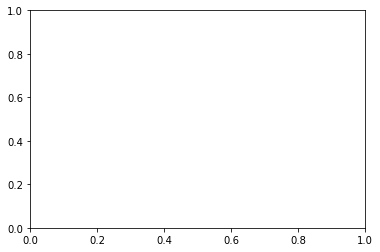

* Recording in progress....
ref_stft_seg: (40, 12), query_stft_seg: (4, 12)
table shape: (41, 41)
i, j: ((1, 1))
i, j: ((1, 2))
i, j: ((1, 3))
i, j: ((1, 4))
i, j: ((1, 5))
error! : index 4 is out of bounds for axis 0 with size 4, <class 'IndexError'>
Recording Stopped.


  File "/var/folders/wf/m9s1kcjn5m3cm0k81x5_k_hc0000gn/T/ipykernel_25186/45872099.py", line 15, in <cell line: 14>
    odtw.run(fig, h, hfig)
  File "/var/folders/wf/m9s1kcjn5m3cm0k81x5_k_hc0000gn/T/ipykernel_25186/730136545.py", line 212, in run
    self.update_path_cost()
  File "/var/folders/wf/m9s1kcjn5m3cm0k81x5_k_hc0000gn/T/ipykernel_25186/730136545.py", line 161, in update_path_cost
    self.update_accumulate_matrix()
  File "/var/folders/wf/m9s1kcjn5m3cm0k81x5_k_hc0000gn/T/ipykernel_25186/730136545.py", line 111, in update_accumulate_matrix
    d = scipy.spatial.distance.euclidean(ref_stft_seg[i - 1], query_stft_seg[j - 1])


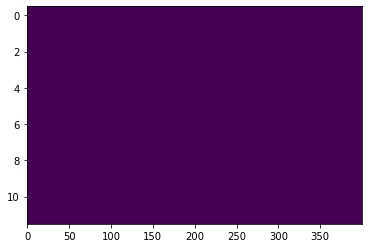

In [63]:
ref_audio_path = "../resources/audio/target/Haydn_Hob.XVI34_1-1.wav"
SAMPLE_RATE = 22050
CHUNK_SIZE = 1024
N_FFT = 512
import traceback

sp = StreamProcessor(SAMPLE_RATE, CHUNK_SIZE, verbose=False)
odtw = OnlineTimeWarping(sp, ref_audio_path, window_size=10, verbose=False)
fig = plt.figure()
ax = fig.gca()
hfig = display(fig, display_id=True)
h = ax.imshow(np.zeros((12, 400)), aspect='auto', vmin=0, vmax=1, interpolation='nearest')

try:
    odtw.run(fig, h, hfig)
    
except Exception as e:
    print(f"error! : {str(e)}, {type(e)}")
    traceback.print_tb(e.__traceback__)
    sp.stop()
    pass

In [135]:
odtw.cost_matrix.shape

(41, 41)

In [136]:
odtw.ref_pointer, odtw.q_index

(44, 8)

In [46]:
import pandas as pd

df = pd.DataFrame(odtw.cost_matrix)
df

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
0,0.0,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
1,inf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.365436,2.382209,4.083226,5.773043,7.079408,8.495882,9.427290,0.0
2,inf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.345666,2.341040,4.009504,5.664069,6.932076,8.321682,9.240819,0.0
3,inf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.293047,2.240777,3.818944,5.392930,6.590242,7.956657,8.848867,0.0
4,inf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.356974,2.307972,3.933685,5.505728,6.694877,8.032213,8.873056,0.0
5,inf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.344869,2.340297,3.978786,5.608736,6.800873,8.133668,8.953435,0.0
6,inf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.284570,2.211317,3.754071,5.320146,6.524275,7.914566,8.835303,0.0
7,inf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.295192,2.232962,3.797769,5.335461,6.524276,7.897212,8.777514,0.0
8,inf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.341950,2.282048,3.900465,5.466538,6.625109,7.947976,8.809420,0.0
9,inf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.366863,2.334658,3.988105,5.620530,6.803636,8.076711,8.877547,0.0


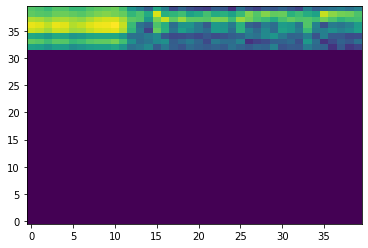

In [138]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(odtw.dist_matrix.T, aspect='auto', origin='lower')

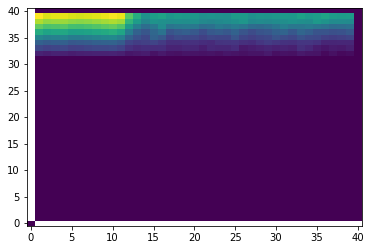

In [139]:
plt.imshow(odtw.cost_matrix.T, aspect='auto', origin='lower')

In [140]:
df = pd.DataFrame(odtw.warping_path)
df

,0,1
0,5,0
1,5,1
2,5,2
3,5,3
4,5,4
5,5,5
6,5,6
7,5,7
8,5,8
9,6,8


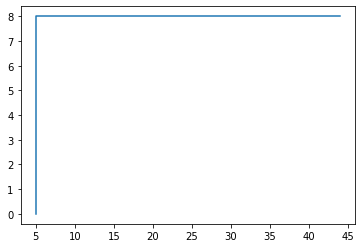

In [141]:
plt.plot(odtw.warping_path[:, 0], odtw.warping_path[:, 1])
plt.show()

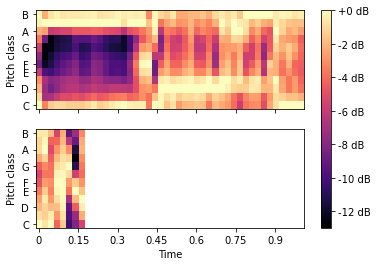

In [142]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
D1 = librosa.amplitude_to_db(np.abs(odtw.ref_stft[:, :odtw.ref_pointer]), ref=np.max)
img = librosa.display.specshow(D1, y_axis='chroma', x_axis='time', ax=ax[0])
ax[0].label_outer()

D2 = librosa.amplitude_to_db(np.abs(odtw.query_stft[:, :odtw.q_index]), ref=np.max)
img = librosa.display.specshow(D2, y_axis='chroma', x_axis='time', ax=ax[1])
ax[1].label_outer()
fig.colorbar(img, ax=ax, format="%+2.f dB")

# plt.imshow(odtw.query_stft[:, :odtw.q_index], aspect='auto')

i, j: (44, 8)
table shape: (45, 9)


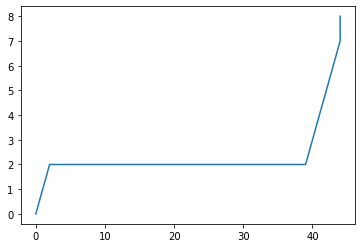

In [41]:
def dtw_table(x, y):
    distance = scipy.spatial.distance.euclidean
    nx = len(x)
    ny = len(y)
    table = np.zeros((nx+1, ny+1))
    
    # Compute left column separately, i.e. j=0.
    table[1:, 0] = np.inf
        
    # Compute top row separately, i.e. i=0.
    table[0, 1:] = np.inf
        
    # Fill in the rest.
    for i in range(1, nx+1):
        for j in range(1, ny+1):
            d = distance(x[i-1], y[j-1])
            table[i, j] = d + min(table[i-1, j], table[i, j-1], table[i-1, j-1])
    return table

def dtw(x, y, table):
    i = len(x)
    j = len(y)
    path = [(i, j)]
    print(f"i, j: {i, j}")
    print(f"table shape: {table.shape}")
    while i > 0 or j > 0:
        minval = np.inf
        if table[i-1, j] < minval:
            minval = table[i-1, j]
            step = (i-1, j)
        if table[i][j-1] < minval:
            minval = table[i, j-1]
            step = (i, j-1)
        if table[i-1][j-1] < minval:
            minval = table[i-1, j-1]
            step = (i-1, j-1)
        path.insert(0, step)
        i, j = step
    return path

D = dtw_table(odtw.ref_stft[:, :odtw.ref_pointer].T, odtw.query_stft[:, :odtw.q_index].T)
path = dtw(odtw.ref_stft[:, :odtw.ref_pointer].T, odtw.query_stft[:, :odtw.q_index].T, D)
plt.plot([i for i, j in path], [j for i, j in path])
plt.show()

In [42]:
import pandas as pd

df = pd.DataFrame(D)
df

,0,1,2,3,4,5,6,7,8
0,0.0,inf,inf,inf,inf,inf,inf,inf,inf
1,inf,0.763906,1.525038,2.598152,3.840440,5.297594,7.345867,9.224375,10.875354
2,inf,2.121968,2.099195,3.310744,4.294718,5.297478,6.947687,8.461795,9.862259
3,inf,3.545559,3.477354,3.953391,5.085559,5.789965,6.998254,8.509391,9.911880
4,inf,4.876066,4.774355,5.236643,5.660564,6.559390,7.549737,8.611463,9.995776
5,inf,6.143378,5.991092,6.460971,6.866360,7.080249,8.303221,9.146767,10.074781
6,inf,7.382236,7.169940,7.644932,8.054950,8.255330,8.816617,9.893630,10.599508
7,inf,8.523927,8.284030,8.734660,9.166785,9.415319,10.037074,10.451572,11.378587
8,inf,9.769278,9.511612,9.961866,10.370874,10.600032,11.180837,11.647706,11.927988
9,inf,10.991425,10.718729,11.164001,11.585034,11.809975,12.391561,12.814644,13.142762


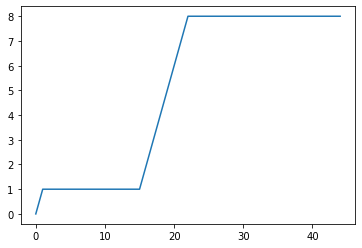

In [145]:
plt.plot([i for i, j in path], [j for i, j in path])
plt.show()

i: 40, j: 40, offset: [  4 -32], ref_until: 0, query_until: 32


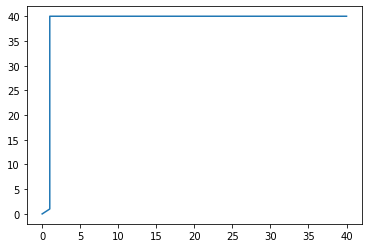

In [153]:
def online_dtw():
    table = odtw.cost_matrix
    i = odtw.dist_matrix.shape[0]
    j = odtw.dist_matrix.shape[1]
    
    ref_until = 0
    query_until = 0
    
    offset = odtw.offset()
    if offset[0] < 0 or offset[1] < 0:
        ref_until = max(i - odtw.ref_pointer, 0)
        query_until = max(j - odtw.q_index, 0)
        
    path = [(i, j)]
    print(f"i: {i}, j: {j}, offset: {offset}, ref_until: {ref_until}, query_until: {query_until}")
    while i > ref_until or j > query_until:
        minval = np.inf
        if table[i - 1, j] < minval:
            minval = table[i - 1, j]
            step = (i - 1, j)
        if table[i][j - 1] < minval:
            minval = table[i, j - 1]
            step = (i, j - 1)
        if table[i - 1][j - 1] < minval:
            minval = table[i - 1, j - 1]
            step = (i - 1, j - 1)
        path.insert(0, step)
        i, j = step
    return path

'''
table = self.cost_matrix
i = self.dist_matrix.shape[0]
j = self.dist_matrix.shape[1]

ref_until = 0
query_until = 0

offset = self.offset()
if offset[0] < 0 or offset[1] < 0:
    ref_until = max(i - self.ref_pointer, 0)
    query_until = max(j - self.q_index, 0)
path = [(i, j)]
while i > ref_until and j > query_until:
    minval = np.inf
    if table[i-1, j] < minval:
        minval = table[i-1, j]
        step = (i-1, j)
    if table[i][j-1] < minval:
        minval = table[i, j-1]
        step = (i, j-1)
    if table[i-1][j-1] < minval:
        minval = table[i-1, j-1]
        step = (i-1, j-1)
    path.insert(0, step)
    i, j = step
path += self.offset()
self.warping_path = path
'''
# x = odtw.ref_stft[:, :odtw.ref_pointer].T
# y =  odtw.query_stft[:, :odtw.q_index].T
# D = dtw_table(x, y)
path = online_dtw()
plt.plot([i for i, j in path], [j for i, j in path])
plt.show()